***change your own path here (colab)***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab_Notebooks/nlp project/project/' #to be changed depending on who runs it

***install tools***

In [ ]:
!pip install transformers
!pip install sentence-transformers
!pip install rank_bm25
!pip install codecarbon
!pip install happytransformer

# 1. First procedure: prepare data

### Libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import torch
from torch import nn
import torch.optim as optim
from copy import deepcopy
import numpy as np
import sys
from codecarbon import EmissionsTracker
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.spatial.distance import cosine

import os
import random

sys.path.append(base_path)

from scorer.main import evaluate
from functools import partial

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Load Data

In [ ]:
train = pd.read_csv(base_path+'train_dataset')
dev = pd.read_csv(base_path+'dev_dataset')

# Removing useless columns

train = train.drop('Unnamed: 0',axis=1)
train = train.drop('0',axis=1)
train[train.duplicated(['tweet_id'], keep=False)]

dev = dev.drop('Unnamed: 0',axis=1)
dev = dev.drop('0',axis=1)
dev[dev.duplicated(['tweet_id'], keep=False)]

vclaim = pd.read_csv(base_path+'vclaim_dataset.csv',sep=',')

#create train - val - test separation
val = train[800:].copy()
test = dev
train = train[:800].copy()

val = val.reset_index().drop('index',axis=1)

In [ ]:
train.head()

,tweet_id,vclaim_id,1,tweet,vclaim
0,tweet-sno-0,vclaim-sno-hero-wombats-australia-fires,1,How are butterflies surviving the #AustralianF...,Wombats are herding animals and inviting them ...
1,tweet-sno-1,vclaim-sno-ilhan-omar-treason-advice-iran,1,Trump needs to immediately divest from his bus...,"In January 2020, U.S. Rep. Ilhan Omar advised ..."
2,tweet-sno-2,vclaim-sno-us-army-sending-texts-on-draft,1,A number of fraudulent text messages informing...,The U.S. Army is sending text messages informi...
3,tweet-sno-3,vclaim-sno-us-army-sending-texts-on-draft,1,Fact check: The U.S. Army is NOT contacting an...,The U.S. Army is sending text messages informi...
4,tweet-sno-4,vclaim-sno-video-of-drone-strike-soleimani,1,The US drone attack on #Soleimani caught on ca...,A video shows the U.S.-ordered drone strike th...


In [ ]:
val.head()

,tweet_id,vclaim_id,1,tweet,vclaim
0,tweet-sno-800,vclaim-sno-reginald-veljohnson-death-hoax,1,Damn #ReginaldVelJohnson thanks u made my chil...,'Family Matters' star Reginald VelJohnson died...
1,tweet-sno-801,vclaim-sno-reginald-veljohnson-death-hoax,1,#RIP: We've just learned that #ReginaldVelJohn...,'Family Matters' star Reginald VelJohnson died...
2,tweet-sno-802,vclaim-sno-reginald-veljohnson-death-hoax,1,Twitter literally trying to kill me! ??? https...,'Family Matters' star Reginald VelJohnson died...
3,tweet-sno-803,vclaim-sno-schools-banning-valentines-offends-...,1,Guess Which State Just BANNED VALENTINES DAY B...,At least one state banned Valentine's Day at s...
4,tweet-sno-804,vclaim-sno-definition-of-trumpery,1,"OED definition of trumpery: 1) deceit, fraud, ...","The English word ""trumpery,"" which derives fro..."


In [ ]:
test.head()

,tweet_id,vclaim_id,1,tweet,vclaim
0,tweet-sno-999,vclaim-sno-single-mother-birth-certificate,1,Republicans in Illinois don't want the child o...,Lawmakers in Illinois proposed a bill to preve...
1,tweet-sno-1000,vclaim-sno-single-mother-birth-certificate,1,Illinois GOP bill attacks single moms: No birt...,Lawmakers in Illinois proposed a bill to preve...
2,tweet-sno-1001,vclaim-sno-michael-savage-removed,1,michael savage who has more viewers then all m...,Radio personality Michael Savage was fired bec...
3,tweet-sno-1002,vclaim-sno-alabama-food-stamps-car,1,The Montgomery Idiocracy strikes again: Alabam...,Republicans in Alabama filed a bill which (if ...
4,tweet-sno-1003,vclaim-sno-alabama-food-stamps-car,1,In Alabama you won't be able to own a car & ge...,Republicans in Alabama filed a bill which (if ...


In [ ]:
vclaim.head()

,Unnamed: 0,title,subtitle,author,date,vclaim_id,vclaim
0,0,Doctored Spock,Did the son of baby specialist Dr. Spock kill ...,David Mikkelson,9 September 2002,vclaim-sno-doctored-spock,The son of child care expert Dr. Benjamin Spoc...
1,1,Maryland Doctor Who Treated Hillary Clinton fo...,Fabricated conspiracy theory holds that Hillar...,David Mikkelson,15 October 2016,vclaim-sno-doctor-who-treated-hillary-clinton-...,A Maryland doctor who participated in a secret...
2,2,"Doctor Saves Baby, Baby Saves Doctor",An incredible story about a doctor and a param...,Dan Evon,25 April 2016,vclaim-sno-doctor-saves-baby-karma,A paramedic saved the doctor who had saved his...
3,3,Is This a Doctor Mourning a Woman Who Died Dur...,A photograph reportedly depicts a crying docto...,Kim LaCapria,6 September 2017,vclaim-sno-doctor-mourning-previously-infertil...,An image depicts a obstetrician grieving after...
4,4,Medicare and Guns,Medicare regulations do not require that docto...,David Mikkelson,26 March 2012,vclaim-sno-doctor-know,Medicare regulations require that doctors ask ...


In [ ]:
train.nunique()

tweet_id     800
vclaim_id    634
1              1
tweet        800
vclaim       634
dtype: int64

In [ ]:
test.nunique(), dev.shape

(tweet_id     199
 vclaim_id    150
 1              1
 tweet        199
 vclaim       150
 dtype: int64, (200, 5))

### Pre-Processing

In [ ]:
# Pre-processing
from functools import reduce
import re

def remove_end(txt):
  #return txt[:txt.rfind('—')]
  txt = txt[:txt.rfind('—')]
  return re.sub('—.+?, [0-9]+','',txt)

def remove_escaped(txt):
  return re.sub(r'&\S+','',txt)

def remove_urls(txt):
  txt = re.sub(r'http\S+','',txt)
  txt = re.sub(r'pic.\S+','',txt)
  txt = re.sub(r'twitter.\S+','',txt)
  return txt

def remove_emoji(txt):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', txt) # no emoji

def remove_leading_spaces(txt):
  return txt.strip()

def text_preprocess(txt):
  text_process_list = [remove_escaped,remove_urls,remove_emoji,remove_end]#,remove_emoji,remove_escaped,remove_end,remove_urls]
  txt = reduce(lambda txt,func: func(txt),text_process_list,txt)
  return txt

train['tweet'] = train['tweet'].apply(lambda x: text_preprocess(x))
val['tweet'] = val['tweet'].apply(lambda x: text_preprocess(x))
test['tweet'] = test['tweet'].apply(lambda x: text_preprocess(x))

train.head()

,tweet_id,vclaim_id,1,tweet,vclaim
0,tweet-sno-0,vclaim-sno-hero-wombats-australia-fires,1,How are butterflies surviving the #AustralianF...,Wombats are herding animals and inviting them ...
1,tweet-sno-1,vclaim-sno-ilhan-omar-treason-advice-iran,1,Trump needs to immediately divest from his bus...,"In January 2020, U.S. Rep. Ilhan Omar advised ..."
2,tweet-sno-2,vclaim-sno-us-army-sending-texts-on-draft,1,A number of fraudulent text messages informing...,The U.S. Army is sending text messages informi...
3,tweet-sno-3,vclaim-sno-us-army-sending-texts-on-draft,1,Fact check: The U.S. Army is NOT contacting an...,The U.S. Army is sending text messages informi...
4,tweet-sno-4,vclaim-sno-video-of-drone-strike-soleimani,1,The US drone attack on #Soleimani caught on ca...,A video shows the U.S.-ordered drone strike th...


In [ ]:
vclaim['subtitle'].isnull().sum()

4

Let's change nan values in subtitle to empty strings

In [ ]:
vclaim['subtitle'] = vclaim['subtitle'].fillna('')
vclaim['subtitle'].isnull().sum()

0

In [ ]:
"""
This code is used to encode the vclaims (putting everything inside a list called sentences)
based on which features we want to use
"""

TYPE = 0 #0: vclaim, 1: title+vclaim, 2: title+subtitle+vclaim

if TYPE == 0:
  sentences = vclaim['vclaim'].tolist()
elif TYPE == 1:
  sentences = vclaim['title'].str.cat(vclaim['vclaim'], sep = ' ').values.tolist()
else:
  sentences = vclaim['title'].str.cat(vclaim['subtitle'].str.cat(vclaim['vclaim'], sep=' '), sep = ' ').values.tolist()


In [ ]:
def parse_df(df):
  tweet_vclaim_pairs = [] #list containing [tweet,vclaim] pairs from train dataset
  for i,row in df.iterrows():
    text = []
    text.append(row['tweet'])
    index_vclaim = vclaim.index[vclaim['vclaim_id'] == row['vclaim_id']]
    text.append(sentences[index_vclaim[0]])
    tweet_vclaim_pairs.append(text)
  return tweet_vclaim_pairs

train_bert_text = parse_df(train)
val_bert_text = parse_df(val)

# 2. Scores on syntactical + pre-trained semantic

Here we test several models (bm25, tf-idf and pretrained models, like bert and sgpt).
We do not apply any training yet, but we just see which is the model with the best score and what are the baselines, with their scores

In [ ]:
import json
from sentence_transformers import util as st_utils
from numpy import dot
from numpy.linalg import norm

class Utils():
  def __init__(self):
    pass

  def sortdict(self,dictionary):
    """
    sortdict: dict -> dict
    For each tweet, sorts the corresponding list of vclaim entries by their scores.
    The resulting dict is in the following form:
    {
      tweet_id: [[vclaim_id,vclaim_score],...]
      ...
      ...
      ...
    }
    """
    for k,v in dictionary.items():
      v = np.array(v)
      dictionary[k] = v[np.argsort(v[:,1].astype(np.float))][::-1].tolist()
    return dictionary

  def parse2file(self,dictionary,file_path):
    """
    parse2file: dict, str -> None
    This function writes the dictionary to the file_path
    """
    with open(base_path+file_path,'w') as f:
      for k,v in dictionary.items():
        str_score = ''
        for i in range(len(v)):
          str_score += k+'\tQ0\t'+v[i][0]+'\t'+str(i+1)+'\t'+str(v[i][1])+'\ttrained\n'
        f.write(str_score)

  def score(self,filename):
    """
    score: str -> (list(float),float)
    Evaluate the obtained dictionary (saved in base_path+filename), print and return MRR and MAP scores
    """
    maps, mrr, _ = evaluate(base_path+'qrels-dev.tsv', base_path+filename)
    print(f"Subtask-2a--english")
    print(f'All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. {maps}')
    print(f'MRR score {mrr}')
    return maps,mrr

  def calculate_similarity(self,model,embeddings,result_file,db=test):
    """
    calculate_similarity: model, matrix of floats, str, database (default test) -> sorted dictionary
    This function calculates the cosine similarity between each tweet with each vclaim (that are inside embeddings)
    It then calls sortdict() and parse2file().
    This function call is often followed by score()
    """
    tweet2vclaim = {}
    for i,tweet_row in db.iterrows():
      tweet = tweet_row['tweet']
      id = tweet_row['tweet_id']
      if id not in tweet2vclaim.keys():
          tweet2vclaim[id] = [] #initialize dict, creating all the keys
    
      if 'encode' in dir(model): #check done to make the function work with more types of models
        tweet_embed = model.encode(tweet, convert_to_tensor=True)
        score_cos = st_utils.cos_sim(tweet_embed, embeddings)[0].tolist()
      else:
        score_cos = []
        tweet_embed = np.array(model.predict(embed(tweet[np.newaxis,:])))
        for el in embeddings:
          el = np.array(el).T
          cos_sim = dot(tweet_embed, el)/(norm(tweet_embed)*norm(el))
          score_cos.append(cos_sim)

      for j in range(len(score_cos)):
          tweet2vclaim[id].append([vclaim.vclaim_id[j], score_cos[j]]) #append vclaims inside dict

    sorted = self.sortdict(tweet2vclaim)
    self.parse2file(tweet2vclaim,result_file)
    return sorted

  def restore_dict(self,filename,result_file):
    """
    restore_dict: str, str -> dictionary
    This function restores a pre-saved dict saved in base_path+filename. It returns the dictionary
    """
    with open(base_path+filename,'r') as f:
      tweet2vclaim = json.load(f)
      tweet2vclaim = self.sortdict(tweet2vclaim)
      self.parse2file(tweet2vclaim,result_file)
    return tweet2vclaim

  def dump_json(self,tweet2vclaim,filename):
    with open(base_path+filename,'w') as f: #I save, from time to time, the data obtained in case of crash
      json.dump(tweet2vclaim,f)

  def start_emissions_tracker(self,path):
    tracker = EmissionsTracker(output_dir=base_path+path)
    tracker.start()
    return tracker

  def stop_emissions_tracker(self,tracker):
    return tracker.stop()

In [ ]:
util = Utils()

### BM25 try

In [ ]:
from rank_bm25 import BM25Okapi

class BM25():
  def __init__(self,sentences,util):
    self.util = util
    self.bm25 = self.get_bm25(sentences)

  def get_bm25(self,sentences):
    docs = []

    for sentence in sentences:
      sentence = str(sentence)
      sentence_words = sentence.split()
      docs.append(sentence_words)

    self.tracker = self.util.start_emissions_tracker('analysis/co2/')

    return BM25Okapi(docs)

  def get_tweet2vclaim(self,test_df):
    # create dict for bm25

    tweet2vclaim = {}
    for i,tweet_row in test_df.iterrows():
      tweet = tweet_row['tweet']
      id = tweet_row['tweet_id']
      if id not in tweet2vclaim.keys():
        tweet2vclaim[id] = []
      vclaim['score'] = self.bm25.get_scores(tweet.split(" "))
      tweet2vclaim[id] = [[id, score] for id, score in zip(vclaim.vclaim_id,vclaim.score)]

    self.util.stop_emissions_tracker(self.tracker)

    self.util.dump_json(tweet2vclaim,'bm25dict.json')

    return tweet2vclaim

In [ ]:
bm25 = BM25(sentences,util)
tweet2vclaim = bm25.get_tweet2vclaim(test)
util.parse2file(tweet2vclaim,'bm25result.txt')

In [ ]:
#tweet2vclaim = util.restore_dict('bm25dict.json','bm25result.txt')

In [ ]:
util.score('bm25result.txt')

Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.36683417085427134, 0.39321608040201006, 0.4020100502512563, 0.41025963149078726, 0.41377314242958246, 0.4151700244294639, 0.41608806046901603]
MRR score 0.4148317790619809


([0.36683417085427134,
  0.39321608040201006,
  0.4020100502512563,
  0.41025963149078726,
  0.41377314242958246,
  0.4151700244294639,
  0.41608806046901603],
 0.4148317790619809)

### TF-IDF try

In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class TFIDF():
  def __init__(self,sentences,util):
    ytrain_corpus = sentences
    self.vectorizer = TfidfVectorizer()
    self.Y_train = self.vectorizer.fit_transform(ytrain_corpus)
    self.util = util
    self.tracker = self.util.start_emissions_tracker('analysis/co2/')

  def get_tweet2vclaim(self,df,filepath):
    xtrain_corpus = df['tweet'].tolist()
    X_train = self.vectorizer.transform(xtrain_corpus)

    cosine = cosine_similarity(X_train,self.Y_train)

    tweet2vclaim = {}
    for i in range(len(cosine)): #create dictionary
      tweet_id = df.iloc[i]['tweet_id']
      tweet2vclaim[tweet_id] = []
      for j in range(len(cosine[i])):
        vclaim_id = vclaim.vclaim_id[j]
        tweet2vclaim[tweet_id].append([vclaim_id,cosine[i][j]])

    self.util.stop_emissions_tracker(self.tracker)

    self.util.dump_json(tweet2vclaim,filepath)

    return tweet2vclaim


In [ ]:
tfidf = TFIDF(sentences,util)
tfidf_test_tweet2vclaim = tfidf.get_tweet2vclaim(test,'tfidfdict_test.json') #for checking performance on test set
tfidf_val_tweet2vclaim = tfidf.get_tweet2vclaim(val,'tfidfdict.json') #for obtaining dict for val set, used later for LambdaMart
util.parse2file(tfidf_test_tweet2vclaim,'tfidfdicttest_result.txt')

In [ ]:
tfidf_dict = util.restore_dict('tfidfdict.json','tfidfdictval_result.txt')
tfidf_dict_test = util.restore_dict('tfidfdict_test.json','tfidfdicttest_result.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
util.score('tfidfdicttest_result.txt')

Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.8165829145728644, 0.8433835845896148, 0.8458961474036851, 0.8480796841349605, 0.8500649894494116, 0.850335047221264, 0.8505296395496014]
MRR score 0.8480170767355311


([0.8165829145728644,
  0.8433835845896148,
  0.8458961474036851,
  0.8480796841349605,
  0.8500649894494116,
  0.850335047221264,
  0.8505296395496014],
 0.8480170767355311)

### BERT try

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

model = SentenceTransformer('all-mpnet-base-v2')
tracker = util.start_emissions_tracker('analysis/co2/')
embeddings = model.encode(sentences, convert_to_tensor=True) #encode vclaims using model
util.calculate_similarity(model,embeddings,'sbertresult.txt')
util.stop_emissions_tracker(tracker)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:591: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

[codecarbon INFO @ 18:16:44] [setup] RAM Tracking...
[codecarbon INFO @ 18:16:44] [setup] GPU Tracking...
[codecarbon INFO @ 18:16:44] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:16:44] [setup] CPU Tracking...
[codecarbon WARNING @ 18:16:44] No CPU tracking mode found. Falling back on CPU constant mode.


Using Maximum Sequence Length:  384


[codecarbon WARNING @ 18:16:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:16:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 18:16:46] >>> Tracker's metadata:
[codecarbon INFO @ 18:16:46]   Platform system: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 18:16:46]   Python version: 3.7.15
[codecarbon INFO @ 18:16:46]   Available RAM : 25.454 GB
[codecarbon INFO @ 18:16:46]   CPU count: 4
[codecarbon INFO @ 18:16:46]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 18:16:46]   GPU count: 1
[codecarbon INFO @ 18:16:46]   GPU model: 1 x Tesla T4
[codecarbon INFO @ 18:17:01] Energy consumed for RAM : 0.000040 kWh. RAM Power : 9.545316696166992 W
[codecarbon INFO @ 18:17:01] Energy consumed for all GPUs : 0.000297 kWh. All GPUs Power : 71.255 W
[codecarbon INFO @ 18:17:01] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 

0.000932634720365321

In [ ]:
util.score('sbertresult.txt')

Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9020100502512562, 0.9384422110552764, 0.9394472361809044, 0.9408431044109435, 0.9412020419558109, 0.9412020419558109, 0.9413308549652841]
MRR score 0.9300243223019675


([0.9020100502512562,
  0.9384422110552764,
  0.9394472361809044,
  0.9408431044109435,
  0.9412020419558109,
  0.9412020419558109,
  0.9413308549652841],
 0.9300243223019675)

This score is already very good, almost reaching the best scores set in the challenge

### SGPT try

In [ ]:
!pip install git+https://github.com/UKPLab/sentence-transformers.git
!pip install --upgrade git+https://github.com/Muennighoff/sentence-transformers.git@sgpt_poolings_specb

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

#our task is asymmetric, so we use 
model = SentenceTransformer('Muennighoff/SGPT-1.3B-weightedmean-msmarco-specb-bitfit')
tracker = util.start_emissions_tracker('analysis/co2/')
embeddings = model.encode(sentences, convert_to_tensor=True)
util.calculate_similarity(model,embeddings,'sgptresult.txt')
util.stop_emissions_tracker(tracker)

In [ ]:
util.score('sgptresult.txt')

Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.8618090452261307, 0.8932160804020101, 0.8979899497487437, 0.8986180904522613, 0.9000375810677318, 0.9007331614072214, 0.9008605250622296]
MRR score 0.889553992398913


([0.8618090452261307,
  0.8932160804020101,
  0.8979899497487437,
  0.8986180904522613,
  0.9000375810677318,
  0.9007331614072214,
  0.9008605250622296],
 0.889553992398913)

The result is not so far off the BERT's one, but there is a huge difference in the number of parameters. The BERT model uses 440M params, while the SGPT model uses 1.3B params.  
For SGPT we could also use heavier models (like the 5.8 params' one) which could outscore BERT, but we take into account the scores-efficiency tradeoff.  
Anyway, we will try to find methods to use GPT models to improve our score.

# 3. Trained neural baseline (LSTM)

In [ ]:
#these copies will be used for baselines, since their tokenization is different

train_base = train.copy()
val_base = val.copy()
test_base = test.copy()
vclaim_base = vclaim.copy()

### Tokenizing

In [ ]:
def pd2dict(df):
  tweet2vclaim = {}
  for i,data in df.iterrows():
    tweet2vclaim[data['tweet_id']] = []
    for j,data2 in df.iterrows():
      tweet2vclaim[data['tweet_id']].append([data2['vclaim_id'],0])
  return tweet2vclaim

In [ ]:
small_train = train_base[:200]
small_val = val_base[:50]

train_dict = pd2dict(small_train)
val_dict = pd2dict(small_val)

In [ ]:
## tokenizing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
# 1st - sentence to words
from tensorflow.keras.preprocessing.text import text_to_word_sequence

T = Tokenizer()

T.fit_on_texts(pd.concat([train_base['tweet'],train_base['vclaim'],val_base['tweet'],val_base['vclaim']]))
T.word_index = {k:v-1 for k,v in T.word_index.items()} # v-1 because it is easier to use indexes starting from 0
T.index_word = {k-1:v for k,v in T.index_word.items()} # same here
word_index = T.word_index
index_word = T.index_word
word_count = dict(T.word_counts)
word_listing = sorted([*word_count.keys()])

# tokenize (str -> id) each set with the tokenizer we have just created

train_base['tweet'] = T.texts_to_sequences(train['tweet'])
train_base['vclaim'] = T.texts_to_sequences(train['vclaim'])
vclaim_base['title'] = T.texts_to_sequences(vclaim['title'])
vclaim_base['vclaim'] = T.texts_to_sequences(vclaim['vclaim'])
val_base['tweet'] = T.texts_to_sequences(val['tweet'])
val_base['vclaim'] = T.texts_to_sequences(val['vclaim'])
test_base['tweet'] = T.texts_to_sequences(test['tweet'])
test_base['vclaim'] = T.texts_to_sequences(test['vclaim'])

### Embeding

In [ ]:
# loading glove 300 embedding model

import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension=300):
    
    emb_model = gloader.load("glove-wiki-gigaword-{}".format(embedding_dimension))

    return emb_model


embedding_dimension = 300

embedding_model = load_embedding_model(embedding_dimension)

In [ ]:
def check_OOV_terms(embedding_model, word_listing):
    """
    input: embedding model (glove-300), word listing
    return words present in our vocabulary which don't have glove embeddings
    """
    return list(set(word_listing) - set(embedding_model.vocab.keys()))


oov_terms = check_OOV_terms(embedding_model, word_listing)

print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(word_listing) * 100))

Total OOV terms: 1318 (16.17%)


In [ ]:
# create embedding matrix

import random
import scipy.sparse

def build_embedding_matrix(embedding_model, embedding_dimension, word_index, vocab_size, oov_terms):
    
    embedding_matrix = np.zeros((vocab_size,embedding_dimension),dtype=np.float32)
    
    for w,i in word_index.items():
        if w not in oov_terms:
            embedding_matrix[i] = embedding_model[w]
        else:
            # dealing with oov terms by setting a random embedding close to 0
            embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
    
    return embedding_matrix

embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_index, len(word_index), oov_terms)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))

Embedding matrix shape: (8151, 300)


### Padding

In [ ]:
from nltk.util import pad_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

lengths = []

lengths.append(len(max(train_base['tweet'], key=len)))
lengths.append(len(max(train_base['vclaim'], key=len)))
lengths.append(len(max(vclaim_base['title'], key=len)))
lengths.append(len(max(vclaim_base['vclaim'], key=len)))
lengths.append(len(max(val_base['tweet'], key=len)))
lengths.append(len(max(val_base['vclaim'], key=len)))
lengths.append(len(max(test_base['tweet'], key=len)))
lengths.append(len(max(test_base['vclaim'], key=len)))

m = max(lengths) #take max sentence length from the datasets

# apply padding based on m

train_base['tweet'] = pd.DataFrame([[i] for i in pad_sequences(train_base['tweet'].to_numpy(),m)])
train_base['vclaim'] = pd.DataFrame([[i] for i in pad_sequences(train_base['vclaim'].to_numpy(),m)])

val_base['tweet'] = pd.DataFrame([[i] for i in pad_sequences(val_base['tweet'].to_numpy(),m)])
val_base['vclaim'] = pd.DataFrame([[i] for i in pad_sequences(val_base['vclaim'].to_numpy(),m)])
test_base['tweet'] = pd.DataFrame([[i] for i in pad_sequences(test_base['tweet'].to_numpy(),m)])
test_base['vclaim'] = pd.DataFrame([[i] for i in pad_sequences(test_base['vclaim'].to_numpy(),m)])
vclaim_base['title'] = pd.DataFrame([[i] for i in pad_sequences(vclaim_base['title'].to_numpy(),m)])
vclaim_base['vclaim'] = pd.DataFrame([[i] for i in pad_sequences(vclaim_base['vclaim'].to_numpy(),m)])

In [ ]:
batch_size = 32

def create_triples(df):
  len_vclaim = len(vclaim_base)
  triplet_df = [] #pd.DataFrame(columns=['tweet', 'positive_vclaim', 'negative_vclaim'])
  for index,row in tqdm(df.iterrows()):
    for i in range(batch_size):
      random_index = np.random.randint(len_vclaim)
      random_vclaim = vclaim_base.loc[random_index]
      #print((random_vclaim['vclaim'] == row['vclaim']).all())
      if (random_vclaim['vclaim'] != row['vclaim']).any():
        triplet_df.append(np.array([row['tweet'], row['vclaim'], random_vclaim['vclaim']]))

        #triplet_train_df.loc[index*batch_size+i] = [row['tweet']] + [row['vclaim']] + [random_vclaim['vclaim']]
      else:
        i-=1
  triplet_df = np.array(triplet_df)
  return triplet_df

triplet_train_df = create_triples(train_base)
triplet_dev_df = create_triples(val_base)


800it [00:04, 180.87it/s]
199it [00:01, 193.94it/s]


###Training LSTM

In [ ]:
import tensorflow as tf
#from tensorflow import keras
from keras import layers, metrics, optimizers
from keras.models import Model

In [ ]:
embed_params = {
    "output_dim": 300,
    "input_dim": len(word_index),
    "input_length": m,
    "weights": embedding_matrix if embedding_matrix is None else [embedding_matrix],
    "mask_zero": True,
    "trainable": False,
    "name": "embedding_layer"
}

class Distance(layers.Layer):
  def __init__(self):
    super(Distance,self).__init__()
  
  def call(self,anchor,claim):
    dist = tf.reduce_sum(tf.square(anchor - claim), -1)
    return dist


class SiameseModel(Model):
  def __init__(self,model,margin=0.3):
    super(SiameseModel,self).__init__()

    self.embed = layers.Embedding(**{key: value for key, value in embed_params.items()})

    anchor = layers.Input(shape=(m),name="anchor")
    positive = layers.Input(shape=(m),name="positive")
    negative = layers.Input(shape=(m),name="negative")

    anchor_embedded = embed(anchor)
    positive_embedded = embed(positive)
    negative_embedded = embed(negative)

    anchor_bdir, positive_bdir, negative_bdir = model(anchor_embedded), model(positive_embedded), model(negative_embedded)

    distance_layer = Distance()
    distance_positive = distance_layer(anchor_bdir,positive_bdir)
    distance_negative = distance_layer(anchor_bdir,negative_bdir)

    self.model = Model(inputs=[anchor,positive,negative],outputs=[distance_positive,distance_negative])
    self.margin = margin
    self.metric = metrics.Mean()

  def get_embed_layer(self):
    return self.embed

  def summary(self):
    return self.model.summary()

  def call(self,input):
    return self.model(input)

  def get_loss(self,positive_distance,negative_distance):
    loss = positive_distance - negative_distance + self.margin
    return tf.maximum(loss,0)

  @property
  def metrics(self):
    return [self.metric]

  def train_step(self,input):
    #x,y,z = input

    with tf.GradientTape() as tape:
      output = self.model(input)
      loss = self.get_loss(output[0],output[1])
    
    gradients = tape.gradient(loss, self.model.trainable_weights)

    self.optimizer.apply_gradients(zip(gradients,self.model.trainable_weights))
    self.metric.update_state(loss)

    return {'loss': self.metric.result()}
  
  def test_step(self,input):
    output = self.model(input)
    loss = self.get_loss(output[0],output[1])

    self.metric.update_state(loss)
    return {'loss': self.metric.result()}

In [ ]:
fit_info = {
    'epochs': 10,
    'batch_size': 32,
    'verbose': True
}

compile_info = {
    'optimizer': optimizers.Adam(learning_rate=1e-3)
}

input = layers.Input(shape=(m,embedding_dimension))

bi_lstm1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input)
bi_lstm2 = layers.Bidirectional(layers.LSTM(128))(bi_lstm1)

model = Model(input,bi_lstm2)

siamese_model = SiameseModel(model)
siamese_model.compile(**compile_info)

siamese_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 107)]        0           []                               
                                                                                                  
 positive (InputLayer)          [(None, 107)]        0           []                               
                                                                                                  
 negative (InputLayer)          [(None, 107)]        0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 107, 300)     2445300     ['anchor[0][0]',                 
                                                                  'positive[0][0]',         

In [ ]:
siamese_model.fit([triplet_train_df[:,0,:],triplet_train_df[:,1,:],triplet_train_df[:,2,:]], validation_data=[triplet_dev_df[:,0,:],triplet_dev_df[:,1,:],triplet_dev_df[:,2,:]],**fit_info)

Epoch 1/10
800/800 [==============================] - ETA: 0s - loss: 0.0342

800/800 [==============================] - 897s 1s/step - loss: 0.0342 - val_loss: 0.1107
Epoch 2/10
800/800 [==============================] - ETA: 0s - loss: 0.0048

800/800 [==============================] - 841s 1s/step - loss: 0.0048 - val_loss: 0.0876
Epoch 3/10
800/800 [==============================] - ETA: 0s - loss: 0.0044

800/800 [==============================] - 844s 1s/step - loss: 0.0044 - val_loss: 0.0931
Epoch 4/10
800/800 [==============================] - ETA: 0s - loss: 0.0028

800/800 [==============================] - 845s 1s/step - loss: 0.0028 - val_loss: 0.1080
Epoch 5/10
800/800 [==============================] - ETA: 0s - loss: 0.0032

800/800 [==============================] - 839s 1s/step - loss: 0.0032 - val_loss: 0.0933
Epoch 6/10
800/800 [==============================] - ETA: 0s - loss: 0.0026

800/800 [==============================] - 842s 1s/step - loss: 0.0026 - val_loss: 0.0952
Epoch 7/10
800/800 [==============================] - ETA: 0s - loss: 8.5672e-04

800/800 [==============================] - 839s 1s/step - loss: 8.5779e-04 - val_loss: 0.1338
Epoch 8/10
800/800 [==============================] - ETA: 0s - loss: 0.0029

800/800 [==============================] - 840s 1s/step - loss: 0.0029 - val_loss: 0.0929
Epoch 9/10
800/800 [==============================] - ETA: 0s - loss: 0.0012

800/800 [==============================] - 841s 1s/step - loss: 0.0012 - val_loss: 0.1132
Epoch 10/10
800/800 [==============================] - ETA: 0s - loss: 8.6013e-04

800/800 [==============================] - 838s 1s/step - loss: 8.6051e-04 - val_loss: 0.1499


In [ ]:
embed = siamese_model.get_embed_layer()

In [ ]:
embeddings = []
for i,row in vclaim_base.iterrows():
  embeddings.append(embed(row['vclaim'][np.newaxis,:]))

In [ ]:
embeddings_predicted = []
for el in embeddings:
  predicted = model.predict(el)
  embeddings_predicted.append(predicted)

In [ ]:
embeddings_predicted = np.array(embeddings_predicted)
embeddings_predicted_squeezed = np.squeeze(embeddings_predicted,axis=1)
embeddings_predicted_squeezed.shape

(13825, 256)

In [ ]:
util.calculate_similarity(model,embeddings_predicted_squeezed,'bilstm.txt',test_base)
util.score('bilstm.txt')

1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.04020100502512563, 0.04606365159128978, 0.0483249581239531, 0.0507677275265215, 0.051781198241440625, 0.05361920631479456, 0.055100443092092055]
MRR score 0.05506951328601533


([0.04020100502512563,
  0.04606365159128978,
  0.0483249581239531,
  0.0507677275265215,
  0.051781198241440625,
  0.05361920631479456,
  0.055100443092092055],
 0.05506951328601533)

# 4. Fine-tuning BERT model

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader

EPOCHS = 50

class SbertFineTuning():
  def __init__(self,train_bert_text,val_bert_text,optim_params,loss_function,txt_file,util,batch_size=64):
    self.model = SentenceTransformer('all-mpnet-base-v2')
    self.train_dataloader = self.parse_tweet_vclaim_pairs(train_bert_text,batch_size)
    self.val_dataloader = self.parse_tweet_vclaim_pairs(val_bert_text,batch_size)
    self.optim_params = optim_params
    self.loss_function = loss_function(self.model)
    self.txt_file = txt_file
    self.util = util
    self.best_model = None

  def get_best_model(self):
    return deepcopy(self.best_model)

  def parse_tweet_vclaim_pairs(self,pairs,batch_size=64):
    """
    Prepare train and val set for sentence_transformers format
    """
    examples = [InputExample(texts = pairs[i]) for i in range(len(pairs))]
    dataloader = DataLoader(examples, shuffle=True, batch_size=batch_size)
    return dataloader

  """
  train_model: loss function, txt_file (where to save dictionary), eval_df (dataset to check how model performs)
  -> train loss, val loss, MRR and MAP scores, best performing model (based on MRR).
  """

  def train_model(self, sentences, test_df=test):
    lowest_val_loss= float('inf')
    train_loss, val_loss = [],[] #scores,[[],[]]
    for i in range(EPOCHS):
      """
      in fit(), loss and dataloader_val are not standard attributes of sentence_transformers library.
      They have been added to calculate the validation error for each epoch.
      """
      train_err, val_err = self.model.fit(train_objectives=[(self.train_dataloader, self.loss_function)], **self.optim_params, epochs=1, output_path=base_path, \
                                     show_progress_bar=True, loss=self.loss_function, dataloader_val=self.val_dataloader)
      train_loss.append(train_err)
      val_loss.append(val_err)
      if val_err[0] < lowest_val_loss:
        lowest_val_loss = val_err[0]
        self.best_model = deepcopy(self.model)
      #if i % 2 == 0:
      #  embeddings = self.model.encode(sentences, convert_to_tensor=True)
      #  self.util.calculate_similarity(self.model,embeddings,self.txt_file,test_df) #tests on MAP and MRR scores are done on test_df
      #  maps, mrr = util.score(self.txt_file)
        #if mrr > best_mrr:
        #  best_mrr = mrr
        #  self.best_model = deepcopy(self.model)

      #scores[0].append(maps)
      #scores[1].append(mrr)
    return train_loss, val_loss #, scores


### MultipleNegativeRankingLoss

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2')
model.fit()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

TypeError: ignored

In [ ]:
optim_params = {
    'weight_decay': 1e-2,
    'optimizer_params': {'lr':1e-2}
}

loss_function = losses.MultipleNegativesRankingLoss
sbert_MNRL = SbertFineTuning(train_bert_text,val_bert_text,optim_params,loss_function,'berttrainedresult.txt',util)

We could have used RerankingEvaluator from SentenceTransformer for evaluating during training, but we have seen that it is way slower than our solution.  
During training, we calculate train and val error. We know that we could achieve higher ranking metrics by testing, during training, the model on the test dataset and take the best model. But we would underestimate the true test error (Elements of Statistical Learning, Hastie et al.).

In [ ]:
MNRLtrain_loss, MNRLval_loss = sbert_MNRL.train_model(sentences)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.2094776859650245
Val error: 0.22061875863437308


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.12764926369373614
Val error: 0.35556942597031593


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.08988844252263124
Val error: 0.22994983615353703


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.06144607067108154
Val error: 0.22387452050679713


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.05958523196526445
Val error: 0.24134228099137545


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.044083376988195457
Val error: 0.24016232749272604


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.0456499465329286
Val error: 0.250170033541508


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.051880082581192255
Val error: 0.27362497977446765


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03665084345266223
Val error: 0.24657611083239317


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.039366047005527295
Val error: 0.23536948184482753


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.036907903456057496
Val error: 0.21076634389464743


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.054984343166534715
Val error: 0.23417697433615103


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03264547522681264
Val error: 0.2250580880790949


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04743111649384865
Val error: 0.24438615737017244


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.044050625417954646
Val error: 0.24840353973559104


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04526188727826453
Val error: 0.25363593362271786


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04784954232701029
Val error: 0.2440984255845251


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04605421737337915
Val error: 0.22993688905262388


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03165412583173467
Val error: 0.2727221315144561


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.037810360779985785
Val error: 0.20568993722554296


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.056676845711011156
Val error: 0.2903592810034752


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03589296595712837
Val error: 0.23712402154046686


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.02527084341048836
Val error: 0.26026083971373737


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04437174782371865
Val error: 0.2891700863838196


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04009387600952043
Val error: 0.23365035990718752


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.020234888567266844
Val error: 0.29516907408833504


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.031760378467599645
Val error: 0.23390429921619216


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03672477133715382
Val error: 0.25065635703504086


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03648320417134808
Val error: 0.24919853976462036


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03831195574289618
Val error: 0.24359799009653216


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03196440141003292
Val error: 0.2075449302792549


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03904051560675725
Val error: 0.266032877843827


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.028874008217826486
Val error: 0.25235728967527393


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04125850530377088
Val error: 0.24174478244094644


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04267722385702655
Val error: 0.25648564406083096


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.036032990391294546
Val error: 0.2270966827054508


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03718994967773771
Val error: 0.23400986852357164


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03187135002092244
Val error: 0.24601146942586638


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04042282586809821
Val error: 0.2295320217963308


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03455408452786147
Val error: 0.3123422786593437


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.021759755090058137
Val error: 0.256552129983902


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.025918719730375763
Val error: 0.24638726469129324


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.02610412544499223
Val error: 0.20364419627003372


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.02956324305761462
Val error: 0.27242724504321814


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03797116813858828
Val error: 0.19508626614697278


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04156009867661991
Val error: 0.24729710593874188


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.03533763375778038
Val error: 0.25991329496901017


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.05077689464311474
Val error: 0.2612996268144343


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.02685500383645726
Val error: 0.2638131881831214


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Train error: 0.04327258252082034
Val error: 0.23244565748609602


In [ ]:
import pickle

with open(base_path+'analysis/MNRLtrain_loss','wb') as f:
  pickle.dump(MNRLtrain_loss,f)

with open(base_path+'analysis/MNRLval_loss','wb') as f:
  pickle.dump(MNRLval_loss,f)

In [ ]:
"""with open(base_path+'analysis/MNRLtrain_loss','rb') as f:
  MNRLtrain_loss = pickle.load(f)

with open(base_path+'analysis/MNRLval_loss','rb') as f:
  MNRLval_loss = pickle.load(f)"""

In [ ]:
best_model = sbert_MNRL.best_model
embeddings = best_model.encode(sentences, convert_to_tensor=True)
mnrl_dict_test = util.calculate_similarity(best_model,embeddings,'mnrl_test.txt',test)

util.score('mnrl_test.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9371859296482412, 0.9577051926298158, 0.9602177554438861, 0.9602177554438861, 0.9607614093861119, 0.9608972235922778, 0.9610163837713347]
MRR score 0.9497098511080182


([0.9371859296482412,
  0.9577051926298158,
  0.9602177554438861,
  0.9602177554438861,
  0.9607614093861119,
  0.9608972235922778,
  0.9610163837713347],
 0.9497098511080182)

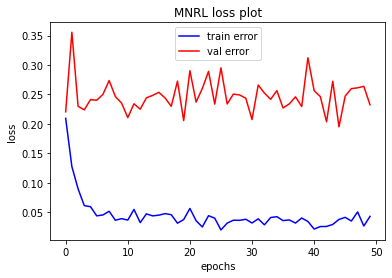

In [ ]:
#plt.subplot(1,3,1)
plt.plot(MNRLtrain_loss, 'b-', label='train error')
plt.plot(MNRLval_loss, 'r-', label='val error')
plt.plot()
plt.title('MNRL loss plot')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

### MegaBatchMarginLoss

Let's try a different ranking loss

In [ ]:
optim_params = {
    'weight_decay': 1e-2,
    'optimizer_params': {'lr':1e-2}
}

loss_function = losses.MegaBatchMarginLoss
sbert_MBML = SbertFineTuning(train_bert_text,val_bert_text,optim_params,loss_function,'berttrainedresultMBML.txt',util,50)

In [ ]:
MBMLtrain_loss, MBMLval_loss = sbert_MBML.train_model(sentences)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.21705165412276983
Val error: 0.23762530460953712


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.17200364405289292
Val error: 0.2154317907989025


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.15949344029650092
Val error: 0.22701357305049896


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.14304865105077624
Val error: 0.23694005981087685


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.13644202426075935
Val error: 0.21166889369487762


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.1190384840592742
Val error: 0.2097589410841465


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.10854682652279735
Val error: 0.20482508093118668


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.10826107067987323
Val error: 0.21303949505090714


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.09709175559692085
Val error: 0.21994869783520699


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.08817169885151088
Val error: 0.21986619755625725


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.08881098171696067
Val error: 0.2036103568971157


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.08287643431685865
Val error: 0.2064756192266941


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.07020963518880308
Val error: 0.21523526683449745


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.07299058651551604
Val error: 0.20818647742271423


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.06054609129205346
Val error: 0.2210911326110363


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.061304871342144907
Val error: 0.2220558598637581


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.0601166378473863
Val error: 0.22635161131620407


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.05266139539889991
Val error: 0.2194765880703926


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.051525215385481715
Val error: 0.23435552790760994


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.05299198522698134
Val error: 0.22580166533589363


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.05110402835998684
Val error: 0.2157401368021965


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.05323500477243215
Val error: 0.24147454649209976


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.04865889507345855
Val error: 0.22395924106240273


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.048523870995268226
Val error: 0.22128302976489067


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03780526097398251
Val error: 0.2410898059606552


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.038671794114634395
Val error: 0.23950890824198723


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.040100389858707786
Val error: 0.229119461029768


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.04148572211852297
Val error: 0.2328646406531334


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03580548087484203
Val error: 0.2238282710313797


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03815142851090059
Val error: 0.21724528819322586


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03873783379094675
Val error: 0.20801936462521553


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.033337809989461675
Val error: 0.21385027468204498


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.031054378778208047
Val error: 0.21619805693626404


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.031112760421819985
Val error: 0.2329411804676056


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03209761608741246
Val error: 0.23102938383817673


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.02365961138275452
Val error: 0.2090366668999195


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.0277474197500851
Val error: 0.219603031873703


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.027373688615625724
Val error: 0.22561819106340408


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03840666310861707
Val error: 0.21280400082468987


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03218367510999087
Val error: 0.19489241391420364


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.034016445963061415
Val error: 0.22549787908792496


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03036775228974875
Val error: 0.21986692771315575


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03351748606655747
Val error: 0.2076643630862236


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.0287239491881337
Val error: 0.21331004798412323


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03340816089803411
Val error: 0.2423625886440277


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.02356657464406453
Val error: 0.22593986243009567


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.02498295584518928
Val error: 0.23305891454219818


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.03367310026078485
Val error: 0.2226758413016796


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.02813565749238478
Val error: 0.23441250622272491


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Train error: 0.027010088248061948
Val error: 0.220046054571867


In [ ]:
import pickle

with open(base_path+'analysis/MBMLtrain_loss','wb') as f:
  pickle.dump(MBMLtrain_loss,f)

with open(base_path+'analysis/MBMLval_loss','wb') as f:
  pickle.dump(MBMLval_loss,f)

In [ ]:
best_model = sbert_MBML.best_model
embeddings = best_model.encode(sentences, convert_to_tensor=True)
mbml_dict_test = util.calculate_similarity(best_model,embeddings,'mbml_test.txt',test)

util.score('mbml_test.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9020100502512562, 0.9242043551088777, 0.9299832495812395, 0.9316582914572865, 0.9316582914572865, 0.9318060892698788, 0.9320018983134193]
MRR score 0.9206953656501027


([0.9020100502512562,
  0.9242043551088777,
  0.9299832495812395,
  0.9316582914572865,
  0.9316582914572865,
  0.9318060892698788,
  0.9320018983134193],
 0.9206953656501027)

With a larger batch size, we would expect to have a better score, but also an higher computational effort. In this case, the notebook goes out of GPU RAM with a batch size > 50.  
Let's plot the results...

In [ ]:
import pickle

with open(base_path+'analysis/MBMLtrain_loss','rb') as f:
  MBMLtrain_loss = pickle.load(f)

with open(base_path+'analysis/MBMLval_loss','rb') as f:
  MBMLval_loss = pickle.load(f)

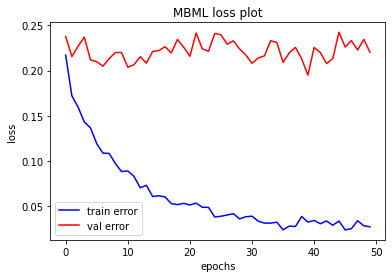

'plt.legend()\nplt.tight_layout()\nplt.show()'

In [ ]:
import matplotlib.pyplot as plt

#plt.subplot(1,3,2)
plt.plot(MBMLtrain_loss, 'b-', label='train error')
plt.plot(MBMLval_loss, 'r-', label='val error')
plt.title('MBML loss plot')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

"""plt.legend()
plt.tight_layout()
plt.show()"""

# 5. Improving the score by creating synthetic data

In [ ]:
!pip install happytransformer

In [ ]:
from happytransformer import HappyGeneration, GENSettings, GENTrainArgs

class GPTGenerators():
  def __init__(self,train_bert_text,FEW_SHOT=True):
    self.model_tweet = HappyGeneration("GPT-NEO", "EleutherAI/gpt-neo-125M")
    #self.model_vclaim = HappyGeneration("GPT-NEO", "EleutherAI/gpt-neo-1.3B")
    self.FEW_SHOT = FEW_SHOT

    """
    creation of training prompt.
    For few shot -> Tweet: {}\nResponse: {}\n\n
    For zero shot -> A tweet is provided:{}\nThis is the claim that verifies the tweet:{}
    """

    self.training_prompt = ''

    if self.FEW_SHOT:
      for i in range(16):
        self.training_prompt += 'Tweet: {}\nResponse: {}\n\n'.format(train_bert_text[i][0], train_bert_text[i][1])

    self.gen_tweet_args = {
      'no_repeat_ngram_size':2,
      'do_sample':True,
      'early_stopping':True,
      'top_k':50,
      'temperature':1,
      'max_length':50
    }

    self.gen_vclaim_args = {
      'no_repeat_ngram_size':2,
      'do_sample':True,
      'early_stopping':True,
      'top_k':50,
      'temperature':.1,
      'max_length':50
    }

  def train(self,train_args,filepath):
    self.model_tweet.train(base_path+filepath,args=train_args)
  
  def parse_text(self,lst_text,parse_file='train'):
    """
    parse_text: pairs of [tweet,vclaim], filename -> None
    append [CLS] to each tweet
    """

    with open(base_path+'{}.txt'.format(parse_file),'w') as f:
      def get_tweets(lst):
        return '[CLS] '+lst[0]
  
      text = ' \n\n'.join(map(get_tweets,lst_text))
      f.write(text)

  def generate_fake_samples(self,sentences,train_bert_text,quantity=400):
    """
    generate_fake_samples: sentences -> vclaim dataset
                           train_bert_text -> tweet,vclaim pairs
                           quantity: number of fake samples to create -> sentences (augmented vclaim), train_bert_text (augmented tweet vclaim pairs)
    """
    self.model_vclaim = HappyGeneration("GPT-NEO", "EleutherAI/gpt-neo-1.3B")
  
    counter = 0
    tweet_args = GENSettings(**self.gen_tweet_args)
    vclaim_args = GENSettings(**self.gen_vclaim_args)
    while counter < quantity:
      text = []
      result = self.model_tweet.generate_text('[CLS] ',args=tweet_args).text
      splitted_result = result.split('. ')

      tweet = '.'.join(splitted_result[:1]) #I take only the first sentence and treat it as a possible tweet

      prompt = deepcopy(self.training_prompt)
      if self.FEW_SHOT:
        prompt += 'Tweet:{}\nResponse:'.format(tweet)
      else:
        prompt += 'A tweet is provided:{}\nThis is the claim that verifies the tweet:'.format(tweet)
      result = self.model_vclaim.generate_text(prompt,args=vclaim_args).text
      result = '.'.join(result.split('.')[:-1])

      sentences.append(result)

      text.append(tweet)
      text.append(result)

      train_bert_text.append(text) #add the newly created pairs to our dataset

      counter += 1
    return sentences, train_bert_text

In [ ]:
gpt_generators = GPTGenerators(train_bert_text,True)

train_file, val_file = 'train','val'
gpt_generators.parse_text(train_bert_text,train_file)
gpt_generators.parse_text(val_bert_text,val_file)

train_args = GENTrainArgs(learning_rate = 1e-5, num_train_epochs = 40)
gpt_generators.train(train_args,'train.txt')

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/560 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-97d4b023be84b40c/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 17
  Num Epochs = 40
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 680
  Number of trainable parameters = 125198592


Step,Training Loss
500,2.881100




Training completed. Do not forget to share your model on huggingface.co/models =)




We can use the code cell above to generate sentences, where the fake tweet and vclaim are separated by [SEP]  
The model is non deterministic.  
To generate new data, we take these new sentences and stop at the first dot encountered.  
We will add 400 samples (half of the training set more or less) and see whether the new data is too noisy or not. We do not apply any preprocessing (apart from getting rid of [SEP]) because the training data was already preprocessed, so we aim to obtain "clean" data.

In [ ]:
sentences, train_bert_text = gpt_generators.generate_fake_samples(sentences,train_bert_text,400)

In [ ]:
import pickle

with open(base_path+'sentences_few.pkl','wb') as f:
  pickle.dump(sentences,f)

with open(base_path+'train_bert_text_few.pkl','wb') as f:
  pickle.dump(train_bert_text,f)

In [ ]:
train_bert_text[-20:]

[[" I wanted to reiterate today that you're on the right track",
  " You're On The Right Track? I'm not sure what you mean by that. I've never heard of anyone saying that they were on a right-track. You are on your right path. Thank you"],
 [' The D.C',
  ' What is the D?  The District of Columbia is located in Maryland. Is the District a State?\n  Response: D is Not a City. Dc is A State'],
 [' This is an incredibly expensive car! The owner is the one to wear the ring',
  ' What Is the Cost of This Car? A car is expensive. But the owner of this car has a ring. Is this a joke?\n  The cost of owning a car in 2019 is $1,000.00'],
 [' The Obama Administration is reportedly planning a nationwide emergency mental health emergency fund, according to a report from The White House',
  ' Has the Obama Admin. Planned a Nationwide Mental Health Emergency Fund? According to The New Yorker, President Obama is planning to create a $1.5 billion emergency health fund to help the mentally ill'],
 [' Yo

We save and load back the 2 lists: loading both GPT and BERT models in the same runtime causes a CUDA out of memory

In [ ]:
import pickle

with open(base_path+'sentences_few.pkl','rb') as f:
  sentences = pickle.load(f)[:13825]

with open(base_path+'train_bert_text_few.pkl','rb') as f:
  train_bert_text = pickle.load(f)

The following training procedures have been deployed on different runtimes.  Both of them train with GPT augmented data. Eventually, they are compared to the standard BERT finetuning.   
The first one trains following a 64-shot prompting procedure.  
The second one trains in a 0-shot prompting fashion, following https://arxiv.org/pdf/2102.07350.pdf  

To perform the different trainings, change the FEW_SHOT parameter accordingly

### Few shot

In [ ]:
optim_params = {
    'weight_decay': 1e-2,
    'optimizer_params': {'lr':1e-2}
}

loss_function = losses.MultipleNegativesRankingLoss
sbert_MNRL_few = SbertFineTuning(train_bert_text,val_bert_text,optim_params,loss_function,'fewshotresult.txt',util,32)
MNRLgpt_train_loss, MNRLgpt_val_loss = sbert_MNRL_few.train_model(sentences)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.26363925331909405
Val error: 0.16698822804859706


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.10301015332439228
Val error: 0.17194724163605965


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.05082857674355373
Val error: 0.1745460357383958


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.03328608560351361
Val error: 0.14876670095795166


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.018908954703396087
Val error: 0.17978326947611226


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02250060098748164
Val error: 0.18583071391497338


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021334482690068206
Val error: 0.18722806658063615


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.030905017443920338
Val error: 0.19411005342512258


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.019593056428436142
Val error: 0.17639602823848172


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.03106936161164317
Val error: 0.15246959775686264


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.032928237632548096
Val error: 0.17934161637510573


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.014028672315027123
Val error: 0.15863626746587606


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.027212764756098438
Val error: 0.17704423729862487


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.014977999320284366
Val error: 0.17570025527051517


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02278649964519948
Val error: 0.13846934879464762


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.020809286866049086
Val error: 0.16914539571319306


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.018532000932425848
Val error: 0.1775240252495028


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.019073922390816733
Val error: 0.17224679612679342


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.019710035673166492
Val error: 0.17281535839928047


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.025685631421143433
Val error: 0.19568018402372087


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.022672502752117765
Val error: 0.18135616224338133


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021611027734730958
Val error: 0.1664703037167783


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01233925807403131
Val error: 0.21689445951155253


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.018280233794173813
Val error: 0.15015795600733586


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.019644942443655486
Val error: 0.1851447052322328


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02367418952130002
Val error: 0.19975637501920573


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021486229180912853
Val error: 0.18051227059082262


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.024096457292647467
Val error: 0.18966977991762438


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01388960526405993
Val error: 0.1713245828203591


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.0202185539099829
Val error: 0.1814121115832157


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021585940326698812
Val error: 0.19120519927569798


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.018347462663721097
Val error: 0.19064736579145705


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.020863262575355628
Val error: 0.19139468504415294


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.023987557575884767
Val error: 0.20230429784818885


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.030837413150660915
Val error: 0.14882700055438494


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01686924913921853
Val error: 0.19831946304033668


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.013463313696296322
Val error: 0.1587562027520367


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02337493577521711
Val error: 0.17927383624815516


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01608945757470792
Val error: 0.2012421339625559


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.006968118342659804
Val error: 0.16257573983498982


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.022441507957218595
Val error: 0.19359377771615982


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021498079726849317
Val error: 0.1945942995371297


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.017748319869401473
Val error: 0.1502637874899457


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.013004724363111708
Val error: 0.21839128008910588


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021448915946836535
Val error: 0.28265175436224255


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.016894979741999504
Val error: 0.20228464454079845


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.009509615994925537
Val error: 0.1855077716921057


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01735524489049567
Val error: 0.17285033691275334


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.016952942469575454
Val error: 0.17436925627823388


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01752954619893755
Val error: 0.20429012408879185


In [ ]:
best_model = sbert_MNRL_few.best_model
embeddings = best_model.encode(sentences, convert_to_tensor=True)
fewshot_dict = util.calculate_similarity(best_model,embeddings,'fewshot_val.txt',val)
fewshot_dict_test = util.calculate_similarity(best_model,embeddings,'fewshot_test.txt',test)

util.score('fewshot_test.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9522613065326633, 0.9669179229480738, 0.9681742043551089, 0.9694304857621442, 0.969726081387329, 0.969837750845732, 0.9699493193371744]
MRR score 0.9586427866738578


([0.9522613065326633,
  0.9669179229480738,
  0.9681742043551089,
  0.9694304857621442,
  0.969726081387329,
  0.969837750845732,
  0.9699493193371744],
 0.9586427866738578)

In [ ]:
import pickle

with open(base_path+'analysis/MNRLgpt_train_loss_few','wb') as f:
  pickle.dump(MNRLgpt_train_loss,f)

with open(base_path+'analysis/MNRLgpt_val_loss_few','wb') as f:
  pickle.dump(MNRLgpt_val_loss,f)

In [ ]:
import pickle

with open(base_path+'fewshot.pkl','wb') as f:
  pickle.dump(fewshot_dict,f)

with open(base_path+'fewshot_test.pkl','wb') as f:
  pickle.dump(fewshot_dict_test,f)

In [ ]:
"""import pickle

with open(base_path+'fewshot_test.pkl','rb') as f:
  fewshot_dict_test = pickle.load(f)

with open(base_path+'fewshot.pkl','rb') as f:
  fewshot_dict = pickle.load(f)"""

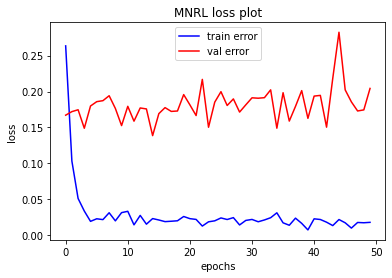

In [ ]:
plt.plot(MNRLgpt_train_loss, 'b-', label='train error')
plt.plot(MNRLgpt_val_loss, 'r-', label='val error')
plt.title('MNRL loss plot')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.show()

### Zero-shot

In [ ]:
optim_params = {
    'weight_decay': 1e-2,
    'optimizer_params': {'lr':1e-2}
}

loss_function = losses.MultipleNegativesRankingLoss
sbert_MNRL_zero = SbertFineTuning(train_bert_text,val_bert_text,optim_params,loss_function,'zeroshotresult.txt',util,32)
MNRLgpt_train_loss_zero, MNRLgpt_val_loss_zero = sbert_MNRL_zero.train_model(sentences)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.465676079259107
Val error: 0.19638555992527731


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.1916176114280365
Val error: 0.22387471795082092


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.0957151106803825
Val error: 0.20606189918388346


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.05508692846878579
Val error: 0.2153678359838003


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.03525641463133261
Val error: 0.23199300707450934


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.03476473807332743
Val error: 0.19797910706672286


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02576942159028381
Val error: 0.19999803706637717


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021436922897057804
Val error: 0.19545043685606547


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.030379460263678704
Val error: 0.22120742349319958


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.023194843670353293
Val error: 0.17661876216464276


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01820950205192754
Val error: 0.1745542783755809


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.027193973997399506
Val error: 0.1836068443953991


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021995459558399346
Val error: 0.2270649623657976


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02247550890407231
Val error: 0.22339230702034132


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.03065057554570223
Val error: 0.209146383235098


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.022946709237753805
Val error: 0.17309016202177321


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02730187005976117
Val error: 0.23455261971269334


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.019901028082944992
Val error: 0.16056590953043529


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.025051057929216
Val error: 0.1902259088653539


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.026298270156410963
Val error: 0.22192865651855495


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.020963378708601293
Val error: 0.26341804436274935


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.029014599797511965
Val error: 0.18363695081955353


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021881072091147008
Val error: 0.19392186775803566


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02111982807362342
Val error: 0.26763537313256947


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01601428793295973
Val error: 0.24436651596001216


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01705816164528522
Val error: 0.22567983929600036


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021081084989801685
Val error: 0.19372934194065497


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.026934687363743586
Val error: 0.21020427492580243


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.021050702736829408
Val error: 0.23317935477410043


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.022887450779212247
Val error: 0.21923401413784763


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02545886681994154
Val error: 0.20342078296068525


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.035910763478712304
Val error: 0.25314285659364294


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02363339856980785
Val error: 0.1913138497620821


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01702208948087278
Val error: 0.1976776910347066


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.022049830012914946
Val error: 0.25754655193304643


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.016820011317529287
Val error: 0.24213605821465276


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.014680484354980044
Val error: 0.2064011222017663


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02318847733687634
Val error: 0.19686019394014562


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02250139544163463
Val error: 0.20953579246997833


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.029289779216541273
Val error: 0.23349897787972754


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.02215033388500543
Val error: 0.21481564747435705


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.013814929629581073
Val error: 0.22118516505828925


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.014247283132710052
Val error: 0.21632374161189155


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.029655097332387845
Val error: 0.24698813800101302


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.014716309126494085
Val error: 0.22025615174581098


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.011058446082690927
Val error: 0.21613611058065935


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.024771327652591647
Val error: 0.19363758819443838


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01844565295016908
Val error: 0.219009986945561


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.01975102464463194
Val error: 0.18624452287830146


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38 [00:00<?, ?it/s]

Train error: 0.024509200639792988
Val error: 0.2119154291493552


In [ ]:
best_model = sbert_MNRL_zero.best_model
embeddings = best_model.encode(sentences, convert_to_tensor=True)
zeroshot_dict = util.calculate_similarity(best_model,embeddings,'zeroshot_val.txt',val)
zeroshot_dict_test = util.calculate_similarity(best_model,embeddings,'zeroshot_test.txt',test)

util.score('zeroshot_test.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.9321608040201005, 0.9568676716917922, 0.9581239530988275, 0.9589614740368508, 0.9592406476828588, 0.9592406476828588, 0.9593372966067617]
MRR score 0.9480307639434451


([0.9321608040201005,
  0.9568676716917922,
  0.9581239530988275,
  0.9589614740368508,
  0.9592406476828588,
  0.9592406476828588,
  0.9593372966067617],
 0.9480307639434451)

In [ ]:
import pickle

with open(base_path+'zeroshot.pkl','wb') as f:
  pickle.dump(zeroshot_dict,f)

with open(base_path+'zeroshot_test.pkl','wb') as f:
  pickle.dump(zeroshot_dict_test,f)

In [ ]:
import pickle

with open(base_path+'analysis/MNRLgpt_train_loss_zero','wb') as f:
  pickle.dump(MNRLgpt_train_loss_zero,f)

with open(base_path+'analysis/MNRLgpt_val_loss_zero','wb') as f:
  pickle.dump(MNRLgpt_val_loss_zero,f)

In [ ]:
"""with open(base_path+'analysis/MNRLgpt_train_loss_zero','rb') as f:
  MNRLgpt_train_loss_zero = pickle.load(f)

with open(base_path+'analysis/MNRLgpt_val_loss_zero','rb') as f:
  MNRLgpt_val_loss_zero = pickle.load(f)"""

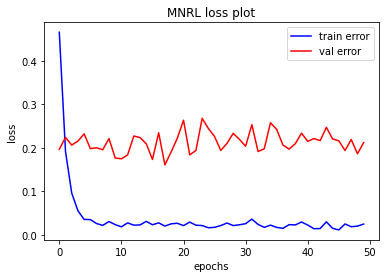

In [ ]:
plt.plot(MNRLgpt_train_loss_zero, 'b-', label='train error')
plt.plot(MNRLgpt_val_loss_zero, 'r-', label='val error')
plt.title('MNRL loss plot')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.show()

The few shot score has improved the base bert score.  
The zero shot score, following https://arxiv.org/pdf/2102.07350.pdf, seems to create more noisy samples and, thus, the score is lower.
Anyway, we have to bear in mind that we used smaller batch sizes than the one used in the standard bert finetuning, due to RAM usage limits. The MNRL loss works better with larger batches, so it is safe to assume that these scores are lower bounds than the actual values we would obtain with the same batch size.

# 6. Lambda-MART

In [ ]:
def keepN(df,dictionary):
  """
  keepN: dataset, dictionary -> dictionary
  This function returns the top 50 vclaims (given dictionary of the form tweet_id: [[vclaim_id,vclaim_score]...])
  If the true vclaim is not in the top-50, we manually add it, replacing the vclaim at position 49.
  """
  for k,v in dictionary.items():
    true_vclaim_id = df.loc[df['tweet_id'] == k]['vclaim_id'].values[0]
    if true_vclaim_id not in np.array(dictionary[k][:50])[:,0]:
      for i in range(50,len(dictionary[k])):
        if dictionary[k][i][0] == true_vclaim_id:
          dictionary[k][49] = dictionary[k][i]
    dictionary[k] = dictionary[k][:50]

  return dictionary

def keep_vclaims(dictionary1,dictionary2):
  """
  keep_vclaims: dictionary, dictionary -> dictionary, list
  Given a dictionary1 which has already been preprocessed by keepN(), this function finds the corresponding vclaims
  in dictionary2, appending the found pairs in a new dictionary. Then, it also returns the old indices.

  While dictionary1 indices are bound between 0-49, dictionary2 indices are produced by a different model (in this case, TF-IDF).
  Hence, the produced indices list can span the whole length of vclaim.
  """
  new_dictionary = {}
  indices = []
  for k,_ in dictionary1.items():
    new_dictionary[k] = []
  for k,v in tqdm(dictionary1.items()):
    for el in dictionary2[k]:
      for i in range(len(dictionary1[k])):
        if el[0] == dictionary1[k][i][0]:
          new_dictionary[k].append(dictionary1[k][i])
          indices.append(i)
          break
      
  return new_dictionary, indices

fewshot_dict = keepN(val,fewshot_dict)
tfidf_dict, indices = keep_vclaims(tfidf_dict,fewshot_dict)

fewshot_dict_test = keepN(test,fewshot_dict_test)
tfidf_dict_test, indices_test = keep_vclaims(tfidf_dict_test,fewshot_dict_test)

100%|██████████| 199/199 [00:03<00:00, 62.52it/s]


In [ ]:
def create_lambdamart_dataset(df,dictionary1,dictionary2,indices):
  """
  create_lambdamart_dataset: dataset, dictionary, dictionary, list -> np array, np array
  This function parses the dictionaries into np arrays following the xgboost format.
  """
  dataset = []
  labels = []
  index = 0
  for k,v in dictionary1.items():
    true_vclaim_id = df.loc[df['tweet_id'] == k]['vclaim_id'].values[0]
    for i in range(50):
      new_row = []
      labels.append(1 if true_vclaim_id == dictionary1[k][i][0] else 0) #if the vclaim is the correct one, we insert 1, 0 otherwise
      new_row.append(None) 

      new_row.append(dictionary1[k][i][1])
      new_row.append(i+1)
      new_row.append(dictionary2[k][i][1])
      new_row.append(indices[index]+1)

      dataset.append(np.array(new_row))
      index+=1

  return np.array(dataset),np.array(labels)

lambdamart_dataset, labels = create_lambdamart_dataset(val,fewshot_dict,tfidf_dict,indices)
lambdamart_dataset_test, labels_test = create_lambdamart_dataset(test,fewshot_dict_test,tfidf_dict_test,indices_test)

In [ ]:
#!pip install xgboost

import xgboost as xgb

class LambdaMART():
  def __init__(self,train_data,test_data,labels_train,labels_test,util):
    self.xgb_train = xgb.DMatrix(train_data, label=labels_train)
    self.xgb_test = xgb.DMatrix(test_data)
    self.params = {'max_depth':3, 'eta':0.3, 'silent':0, 'objective':'rank:pairwise', 'num_round':5, 'gamma':0.0}
    self.model = None
    self.util = util

  def train(self):
    self.model = xgb.train(self.params,self.xgb_train)

  def plot_tree(self,num_trees=8):
    xgb.plot_tree(self.model, num_trees=num_trees)
    fig = plt.gcf()
    fig.set_size_inches(150, 300)

  def plot_importance(self):
    ax = xgb.plot_importance(self.model, color='red')
    fig = ax.figure
    fig.set_size_inches(10, 10)

  def predict(self):
    return self.model.predict(self.xgb_test)

  def create_dict(self,dictionary,predictions):
    """
    create_dict: dictionary, list -> dictionary
    This function creates a new dictionary, with the same ids (vclaim and tweet ids) as the one given in input,
    and with the scores given by the predictions.
    Then, it parses the new dictionary into a file
    """
    d = {}
    counter = 0
    for k,v in dictionary.items():
      d[k] = []
      for j in range(50):
        d[k].append([v[j][0],predictions[j+counter]])
      counter+=50
    sorted = util.sortdict(d)
    util.parse2file(sorted,'lambdaresult.txt')
    return sorted

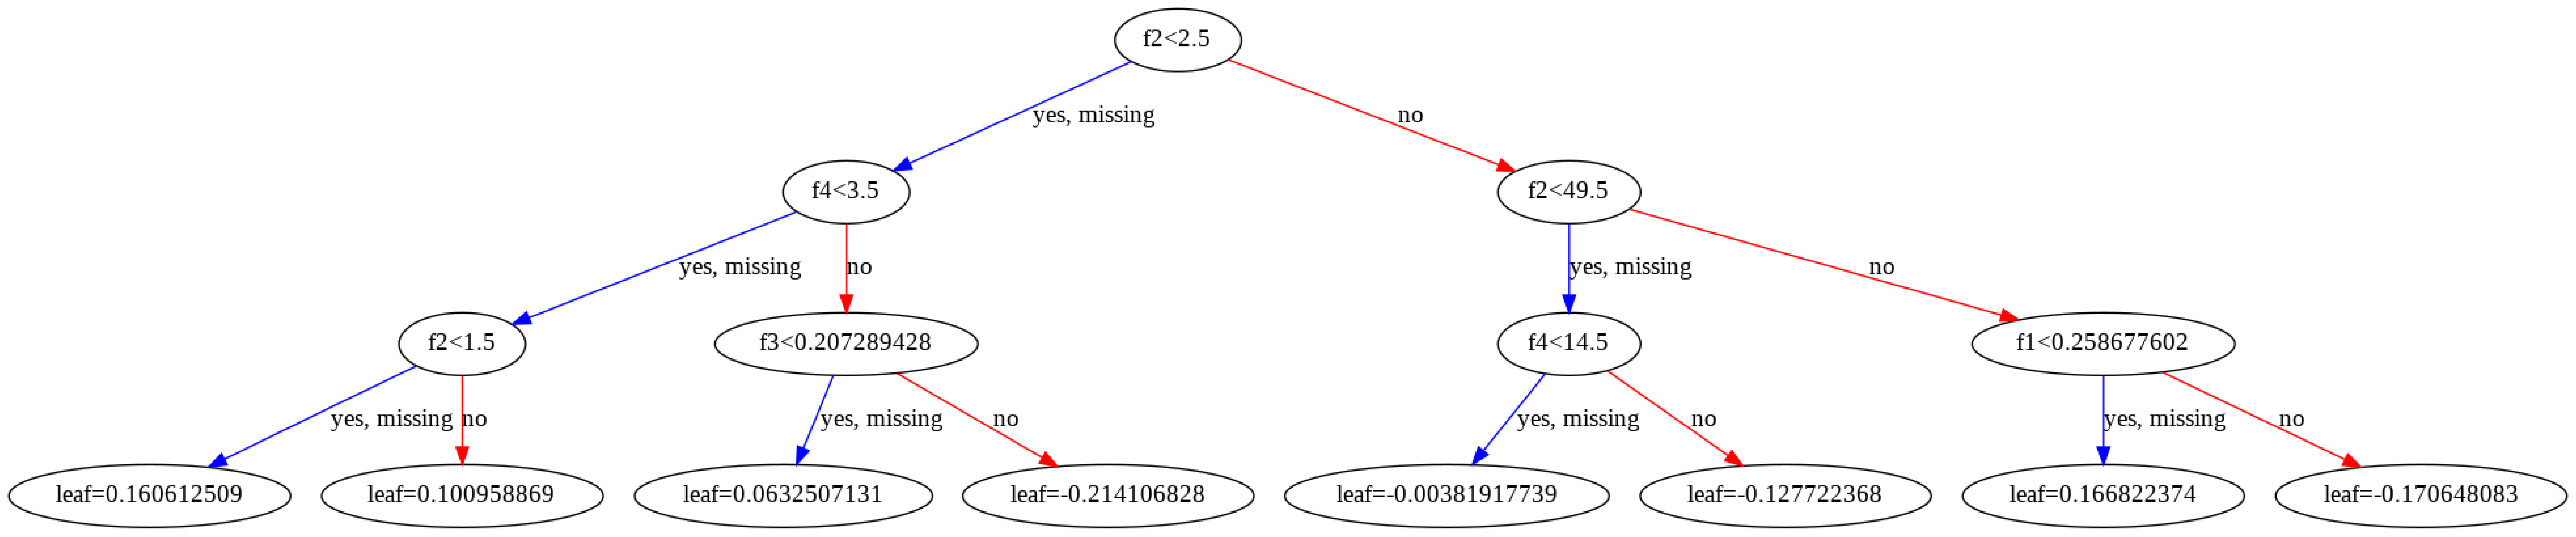

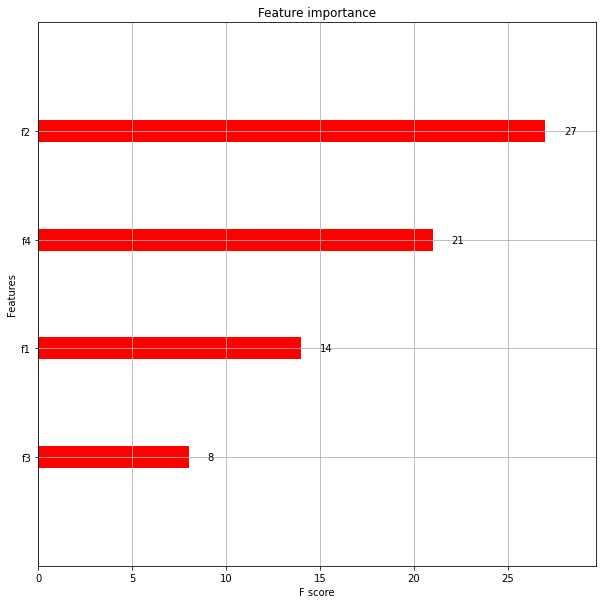

In [ ]:
lambdamart = LambdaMART(lambdamart_dataset,lambdamart_dataset_test,labels,labels_test,util)
lambdamart.train()
lambdamart.plot_tree()
lambdamart.plot_importance()

In [ ]:
predictions = lambdamart.predict()
_ = lambdamart.create_dict(fewshot_dict_test,predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
util.score('lambdaresult.txt')

Subtask-2a--english
All MAP scores on threshold from [1, 3, 5, 10, 20, 50, 1000]. [0.957286432160804, 0.9786432160804021, 0.9786432160804021, 0.9786432160804021, 0.9786432160804021, 0.9791010129567709, 0.9791010129567709]
MRR score 0.9677944802934543


([0.957286432160804,
  0.9786432160804021,
  0.9786432160804021,
  0.9786432160804021,
  0.9786432160804021,
  0.9791010129567709,
  0.9791010129567709],
 0.9677944802934543)

# 7. Analysis on computation and CO2 emissions

In the notebook, we have gathered some information about the co2 emissions of every model. In the chart below, we can see a summary of these values

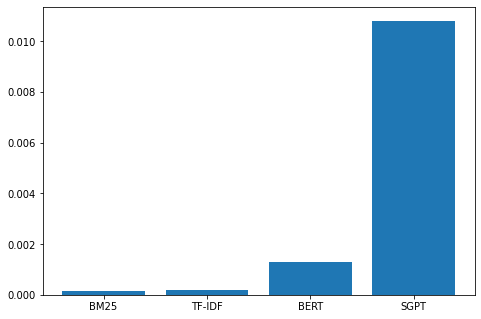

In [ ]:
emissions_df = pd.read_csv(base_path+"analysis/co2/emissions.csv")
emissions = emissions_df["emissions"].tolist()[:5]
emissions.pop(2)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model_names = ['BM25', 'TF-IDF', 'BERT', 'SGPT']
ax.bar(model_names,emissions)
plt.show()

We can see that, during inference, semantical models seem to be worse and produce more emissions.  
SGPT has a much worse performance due to the size of its network.  
Since training and data augmentation procedures may be very demanding with regards to co2 emissions and computational costs, it would be advised to give up on precision and fall back to easier models, like TF-IDF or not fine-tuned SBERT, which already achieve good scores 